## Name: Sai Sriharsha Griddaluru
## CUID: C15358926

In [7]:
## ----------------------------------------------
## :: import necessary libraries and modules ::
## ----------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
import os


In [8]:
## --------------------------------------------------
## :: set manual seed for reproducibility ::
## --------------------------------------------------
torch.manual_seed(1)

## ----------------------------------------------------
## :: setup device for computation (CPU or CUDA) ::
## ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)


Device: cuda


In [9]:
## --------------------------------------
## :: hyperparameters and constants ::
## --------------------------------------
LEARNING_RATE = 5e-5    ## :: learning rate for optimizers ::
BATCH_SIZE = 128        ## :: batch size for DataLoader ::
IMAGE_SIZE = 64         ## :: input image size ::
CHANNELS_IMG = 3        ## :: number of image channels (RGB) ::
NOISE_DIM = 100         ## :: noise dimension for generator ::
NUM_EPOCHS = 40         ## :: number of training epochs ::
FEATURES_DISC = 64      ## :: feature size for discriminator ::
FEATURES_GEN = 64       ## :: feature size for generator ::
beta = 0.5              ## :: beta for Adam optimizer ::

In [10]:
## -----------------------------------------------------
## :: create directories if not already present ::
## -----------------------------------------------------
if not os.path.exists('results'):  ## :: check and create 'Results' directory ::
    os.makedirs('results')

if not os.path.exists('models'):  ## :: check and create 'Models' directory ::
    os.makedirs('models')


Files already downloaded and verified


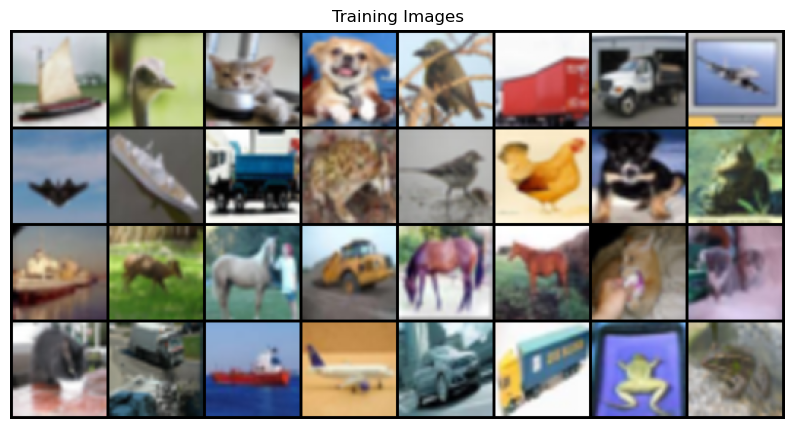

In [11]:
## ---------------------------------------------------------------
## :: download and load the CIFAR-10 dataset with transformations ::
## ---------------------------------------------------------------
dataset = datasets.CIFAR10(
    root="./dataset/CIFAR10data",     ## :: specify the root directory for data storage ::
    download=True,                   ## :: download dataset if not available locally ::
    transform=transforms.Compose([   ## :: apply data transformations ::
        transforms.Resize(64),       ## :: resize images to 64x64 ::
        transforms.ToTensor(),       ## :: convert images to tensor format ::
        transforms.Normalize(        ## :: normalize images with mean and std for RGB channels ::
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        ),
    ])
)

## -----------------------------------------------
## :: create DataLoader for CIFAR-10 dataset ::
## -----------------------------------------------
dataloader = torch.utils.data.DataLoader(
    dataset,               ## :: pass the dataset object ::
    batch_size=BATCH_SIZE, ## :: batch size defined earlier ::
    shuffle=True,          ## :: shuffle data for better training ::
    num_workers=2          ## :: use 2 worker threads for loading data ::
)

## ---------------------------------------------------
## :: visualize a batch of training images ::
## ---------------------------------------------------
real_batch = next(iter(dataloader))  ## :: fetch the next batch of images ::

plt.figure(figsize=(10, 10))         ## :: set figure size for plotting ::
plt.axis("off")                      ## :: hide axes for cleaner visualization ::
plt.title("Training Images")         ## :: add a title to the plot ::
plt.imshow(
    np.transpose(                    ## :: convert PyTorch tensor to NumPy array for display ::
        utils.make_grid(             ## :: arrange the batch of images into a grid ::
            real_batch[0].to(device)[:32],  ## :: take first 32 images from the batch ::
            padding=2,                       ## :: padding between images in the grid ::
            normalize=True                   ## :: normalize images for better visualization ::
        ).cpu(),                             
        (1, 2, 0)                   ## :: transpose dimensions for matplotlib compatibility ::
    )
)

In [12]:
## ====================================================
## :: Define the Discriminator class for GAN model ::
## ====================================================
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            ## :: initial convolution block, reduces spatial dimensions by 2 ::
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),  ## :: apply LeakyReLU activation ::

            ## :: apply custom Dnet blocks sequentially for feature extraction ::
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      ## :: output: 128 channels ::
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  ## :: output: 256 channels ::
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  ## :: output: 512 channels ::

            ## :: final convolution layer, reduces to a 1x1 spatial dimension ::
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),  ## :: apply Sigmoid activation for binary classification ::
        )

    ## ------------------------------------------
    ## :: Define a custom convolutional block ::
    ## ------------------------------------------
    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),  ## :: activation function ::
        )

    ## ---------------------------------
    ## :: Forward pass for Discriminator ::
    ## ---------------------------------
    def forward(self, x):
        return self.disc(x)


## ==================================================
## :: Define the Generator class for GAN model ::
## ==================================================
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            ## :: transpose convolution blocks for upsampling ::
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  ## :: output: 4x4 image ::
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  ## :: output: 8x8 image ::
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),   ## :: output: 16x16 image ::
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),   ## :: output: 32x32 image ::

            ## :: final transpose convolution layer ::
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),  ## :: normalize output to [-1, 1] for image generation ::
        )

    ## ---------------------------------------------------
    ## :: Define a custom transpose convolutional block ::
    ## ---------------------------------------------------
    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),  ## :: normalize feature maps ::
            nn.ReLU(),  ## :: activation function ::
        )

    ## ---------------------------------
    ## :: Forward pass for Generator ::
    ## ---------------------------------
    def forward(self, x):
        return self.net(x)


In [13]:
## ====================================================
## :: Initialize weights based on DCGAN paper :: 
## ====================================================
def initialize_weights(model):
    ## :: Iterate over all layers in the model ::
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            ## :: Initialize weights with normal distribution (mean=0, std=0.02) ::
            nn.init.normal_(m.weight.data, 0.0, 0.02)

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)  ## :: Generator instance ::
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)  ## :: Discriminator instance ::


initialize_weights(gen)  ## :: Initialize Generator weights ::
initialize_weights(disc)  ## :: Initialize Discriminator weights ::

optimGenerator = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))  ## :: Adam optimizer for Generator ::
optimDiscriminator = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))  ## :: Adam optimizer for Discriminator ::

criterion = nn.BCELoss()  ## :: Binary Cross-Entropy loss for binary classification task ::

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)  ## :: Fixed noise for evaluation (32 random samples) ::

step = 0  ## :: Initialize training step counter ::
gen.train(), disc.train()  ## :: Set Generator and Discriminator in training mode ::


(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [14]:
## ========================================================================
## :: InceptionV3 Model - Feature Maps Extraction ::
## ========================================================================
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    ## :: Index of default block of inception to return ::
    ## :: corresponds to output of final average pooling ::
    DEFAULT_BLOCK_INDEX = 3

    ## :: Maps feature dimensionality to their output blocks indices ::
    BLOCK_INDEX_BY_DIM = {
        64: 0,    ## :: First max pooling features ::
        192: 1,   ## :: Second max pooling features ::
        768: 2,   ## :: Pre-aux classifier features ::
        2048: 3   ## :: Final average pooling features ::
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        ## :: Store parameters for resizing, normalization, and output blocks ::
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        ## :: Assert block index is within valid range ::
        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        ## :: Initialize a list to store the blocks ::
        self.blocks = nn.ModuleList()

        ## :: Load Pretrained InceptionV3 Model ::
        inception = models.inception_v3(pretrained=True)

        ## ============================================================
        ## :: Define Blocks in the InceptionV3 Network ::
        ## ============================================================

        ## :: Block 0: input to maxpool1 ::
        block0 = [
            inception.Conv2d_1a_3x3, 
            inception.Conv2d_2a_3x3, 
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        ## :: Block 1: maxpool1 to maxpool2 ::
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        ## :: Block 2: maxpool2 to aux classifier ::
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        ## :: Block 3: aux classifier to final avgpool ::
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        ## :: Set parameters to require gradients if specified ::
        for param in self.parameters():
            param.requires_grad = requires_grad

    ## ====================================================================
    ## :: Forward Pass for Feature Map Extraction ::
    ## ====================================================================
    def forward(self, inp):
        outp = []  ## :: List to store outputs from specified blocks ::
        x = inp    ## :: Input to the network ::

        ## :: Resize input image to 299x299 for InceptionV3 model ::
        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        ## :: Normalize input (scale to range [-1, 1]) ::
        if self.normalize_input:
            x = 2 * x - 1  ## :: Scale from range (0, 1) to range (-1, 1) ::

        ## :: Pass through blocks and capture specified outputs ::
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            ## :: Break once the last needed block is processed ::
            if idx == self.last_needed_block:
                break

        return outp  ## :: Return feature maps from selected blocks ::


## =======================================================
## :: Initialize Model with Feature Map Block Selection ::
## =======================================================
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]  ## :: Select block index for final avgpool features ::
model = InceptionV3([block_idx])  ## :: Instantiate model with selected block ::
model = model.cuda()  ## :: Move model to GPU if available ::

/home/sgridda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sgridda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
## ====================================================================
## :: Function to Calculate Activation Statistics for Images ::
## ====================================================================
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()   ## :: Set model to evaluation mode ::
    
    act = np.empty((len(images), dims))  ## :: Initialize empty array for activations ::
    
    ## :: Load images to GPU if specified, otherwise keep on CPU ::
    if cuda:
        batch = images.cuda()
    else:
        batch = images

    ## :: Get the model output, using the first block for feature extraction ::
    pred = model(batch)[0]
    
    ## :: Perform adaptive average pooling to get 1x1 output if necessary ::
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    ## :: Flatten activations and store them in numpy array ::
    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    ## :: Compute mean and covariance of activations ::
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma  ## :: Return mean and covariance of activations ::

## ====================================================================
## :: Function to Calculate the Frechet Inception Distance (FID) ::
## ====================================================================
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    ## :: Ensure that input means and covariances are at least 1D and 2D ::
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    ## :: Assert means and covariances are of the same shape ::
    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    ## :: Compute the difference between mean vectors ::
    diff = mu1 - mu2

    ## :: Compute the square root of the product of covariances (covmean) ::
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    ## :: Handle potential non-finite covmean by adding a small offset ::
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    ## :: Ensure covmean is real by checking for imaginary components ::
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    ## :: Compute the trace of the covariance mean matrix ::
    tr_covmean = np.trace(covmean)

    ## :: Return the Frechet Inception Distance value ::
    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

## ====================================================================
## :: Function to Calculate FID Between Real and Fake Images ::
## ====================================================================
def calculate_fretchet(images_real, images_fake, model):
    ## :: Calculate activation statistics for real and fake images ::
    mu_1, std_1 = calculate_activation_statistics(images_real, model, cuda=True)
    mu_2, std_2 = calculate_activation_statistics(images_fake, model, cuda=True)
    
    ## :: Compute the Frechet Inception Distance (FID) ::
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    
    return fid_value  ## :: Return the FID value ::


In [16]:
## ====================================================================
## :: Training Loop for GAN Model ::
## ====================================================================
GenLoss = []      ## :: List to store generator loss values ::
DiscLoss = []     ## :: List to store discriminator loss values ::
img_list = []     ## :: List to store generated images ::
FID_list = []     ## :: List to store FID scores for each epoch ::
iters = 0         ## :: Iteration counter ::

print("training...")  ## :: Print training start message ::

# Start timing the training process
time_start = time.time()  

## :: Loop over epochs ::
for epoch in range(NUM_EPOCHS):
    epoch = epoch + 1  ## :: Increment epoch counter by 1 ::

    ## :: Loop over batches in dataloader ::
    for batch_idx, data in enumerate(dataloader, 0):
        ## :: Training with real batch data ::
        real = data[0].to(device)  ## :: Move real images to device (GPU/CPU) ::
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)  ## :: Generate random noise for fake images ::
        fake = gen(noise)  ## :: Generate fake images using the generator ::

        ## ===================================================================
        ## :: Train Discriminator: max log(D(x)) + log(1 - D(G(z))) ::
        ## ===================================================================
        disc_real = disc(real).reshape(-1)  ## :: Get discriminator output for real images ::
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))  ## :: Loss for real images ::
        disc_fake = disc(fake.detach()).reshape(-1)  ## :: Get discriminator output for fake images (detach to avoid updating generator) ::
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))  ## :: Loss for fake images ::
        loss_disc = (loss_disc_real + loss_disc_fake) / 2  ## :: Combine the losses for discriminator ::

        disc.zero_grad()  ## :: Zero out discriminator gradients ::
        loss_disc.backward()  ## :: Backpropagate discriminator loss ::
        optimDiscriminator.step()  ## :: Update discriminator parameters ::

        ## ===================================================================
        ## :: Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))) ::
        ## ===================================================================
        output = disc(fake).reshape(-1)  ## :: Get discriminator output for fake images ::
        loss_gen = criterion(output, torch.ones_like(output))  ## :: Generator loss (aim for fake to be classified as real) ::
        
        gen.zero_grad()  ## :: Zero out generator gradients ::
        loss_gen.backward()  ## :: Backpropagate generator loss ::
        optimGenerator.step()  ## :: Update generator parameters ::
        
        GenLoss.append(loss_gen.detach().cpu())  ## :: Store generator loss ::
        DiscLoss.append(loss_disc.detach().cpu())  ## :: Store discriminator loss ::

        ## ===================================================================
        ## :: Check Generator performance and save images every 500 steps ::
        ## ===================================================================
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():  ## :: Disable gradient calculation for inference ::
                fake = gen(fixed_noise).detach().cpu()  ## :: Generate fake images with fixed noise ::
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))  ## :: Append generated image to list ::

        iters += 1  ## :: Increment iteration counter ::

    ## ===================================================================
    ## :: Calculate FID for the epoch ::
    ## ===================================================================
    fretchet_dist = calculate_fretchet(real, fake, model)  ## :: Calculate FID score for real vs fake images ::
    FID_list.append(fretchet_dist)  ## :: Store FID score for the epoch ::

    ## ===================================================================
    ## :: Print loss and FID information every 5 epochs ::
    ## ===================================================================
    if epoch % 5 == 0:
        print(f'\nEpoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} '
              f'Loss Discriminator: {loss_disc:.3f}, Loss Generator: {loss_gen:.3f} FID: {fretchet_dist:.3f}')
    
    ## ===================================================================
    ## :: Save Generated and Real Images every epoch ::
    ## ===================================================================
    images = gen(fixed_noise)  ## :: Generate fake images for saving ::
    
    ## :: Ensure directories for saving images exist ::
    if not os.path.exists('results/DCGAN_FAKE'):
        os.makedirs('results/DCGAN_FAKE')
    if not os.path.exists('results/DCGAN_REAL'):
        os.makedirs('results/DCGAN_REAL')

    ## :: Save generated fake images ::
    utils.save_image(images.detach(), f'results/DCGAN_FAKE/DCGAN50_epoch_{epoch:03d}.png', normalize=True)

    ## :: Save real images from the current batch ::
    utils.save_image(real.detach(), f'results/DCGAN_REAL/DCGAN50_epoch_{epoch:03d}.png', normalize=True)

# End timing the training process
time_end = time.time()  
print(f'\n\nelapsed time: {time_end - time_start:.2f} s.')  ## :: Print total training time ::


training...

Epoch [5/40] Batch 390/391 Loss Discriminator: 0.452, Loss Generator: 1.423 FID: 379.433

Epoch [10/40] Batch 390/391 Loss Discriminator: 0.602, Loss Generator: 0.885 FID: 320.215

Epoch [15/40] Batch 390/391 Loss Discriminator: 0.561, Loss Generator: 1.107 FID: 321.819

Epoch [20/40] Batch 390/391 Loss Discriminator: 0.664, Loss Generator: 0.968 FID: 278.011

Epoch [25/40] Batch 390/391 Loss Discriminator: 0.652, Loss Generator: 0.753 FID: 240.694

Epoch [30/40] Batch 390/391 Loss Discriminator: 0.649, Loss Generator: 0.784 FID: 225.319

Epoch [35/40] Batch 390/391 Loss Discriminator: 0.621, Loss Generator: 1.158 FID: 228.421

Epoch [40/40] Batch 390/391 Loss Discriminator: 0.666, Loss Generator: 0.939 FID: 236.565


elapsed time: 774.34 s.


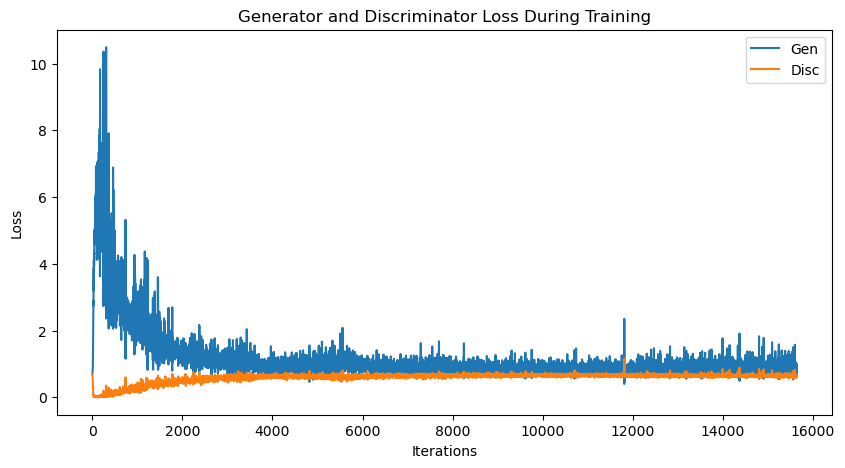

In [18]:
if not os.path.exists('results/Loss_Data'):
    os.makedirs('results/Loss_Data')  ## :: Create directory for loss data storage ::

# Save Generator and Discriminator losses as .npy files
np.save('results/Loss_Data/DCGAN_GLoss', GenLoss)  ## :: Save generator loss data ::
np.save('results/Loss_Data/DCGAN_DLoss', DiscLoss)  ## :: Save discriminator loss data ::

# Load previously saved loss data
GenLoss = np.load('results/Loss_Data/DCGAN_GLoss.npy')  ## :: Load generator loss data ::
DiscLoss = np.load('results/Loss_Data/DCGAN_DLoss.npy')  ## :: Load discriminator loss data ::

# Plotting the loss data
plt.figure(figsize=(10, 5))  ## :: Set figure size for plot ::
plt.title("Generator and Discriminator Loss During Training")  ## :: Set plot title ::
plt.plot(GenLoss, label="Gen")  ## :: Plot generator loss ::
plt.plot(DiscLoss, label="Disc")  ## :: Plot discriminator loss ::
plt.xlabel("Iterations")  ## :: Set x-axis label ::
plt.ylabel("Loss")  ## :: Set y-axis label ::
plt.legend()  ## :: Display legend for the plot ::

# Save the plot as a PDF file
plt.savefig('results/loss.pdf', format='pdf', bbox_inches='tight')  ## :: Save plot as PDF ::

# Show the plot
plt.show()  ## :: Display the plot ::

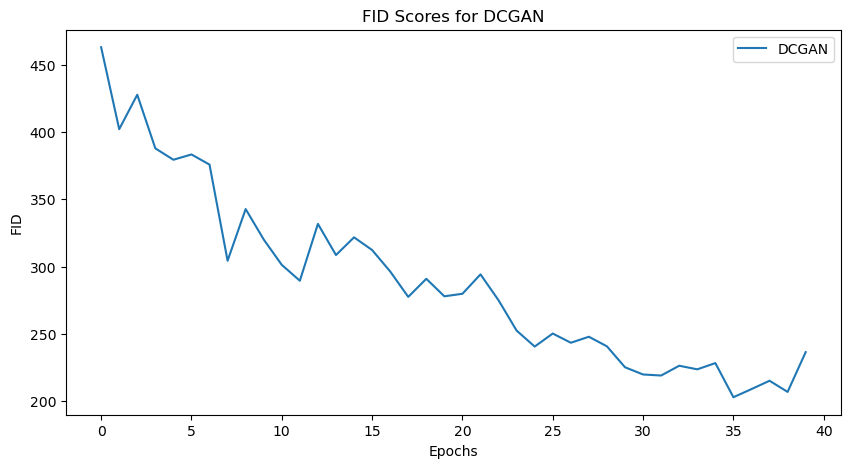

(203.0766158165669, 463.0058002760315, 288.37839973230365, 236.56490635906977)

In [19]:
## ====================================================================
## :: Plotting and Saving FID Scores ::
## ====================================================================
# Create a figure for plotting FID scores
plt.figure(figsize=(10, 5))  ## :: Set figure size for plot ::
plt.title("FID Scores for DCGAN")  ## :: Set plot title ::
plt.plot(FID_list, label="DCGAN")  ## :: Plot FID scores for DCGAN ::
plt.xlabel("Epochs")  ## :: Set x-axis label ::
plt.ylabel("FID")  ## :: Set y-axis label ::
plt.legend()  ## :: Display legend for the plot ::

# Save the plot as a PDF
plt.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')  ## :: Save FID plot as PDF ::
plt.show()  ## :: Display the plot ::

## ====================================================================
## :: Saving FID Scores and Analyzing Loss Data ::
## ====================================================================
# Check if directory exists for saving FID scores, create if not
if not os.path.exists('Results/FID_score'):  
    os.makedirs('Results/FID_score')  ## :: Create directory for FID scores storage ::

# Save FID list as a .npy file
np.save('Results/FID_score/DC_FID', FID_list)  ## :: Save FID scores data ::

# Print statistics for generator and discriminator losses
np.mean(GenLoss), np.mean(DiscLoss), np.min(GenLoss), np.min(DiscLoss), GenLoss[-1], DiscLoss[-1]  ## :: Display generator and discriminator loss statistics ::

# Print statistics for FID scores
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-1]  ## :: Display FID score statistics ::
